 # Two high-level analyses:
 - Predict performance (accuracy) using a regression
 - Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

 For github issues and brainstorming features and analyses, use github:
 - https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser as parser
import parse as str_parse
import time
from datetime import datetime, timezone
import csv
from sklearn import svm
import sklearn.feature_selection
from sklearn.feature_selection import SelectFromModel
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from new_proximity.intersection_proximity import compute_proximity

In [2]:
users = pd.read_csv('ml-users.csv')
users = users.set_index('user_id')

In [3]:
# Users w/ accuracies below 65% and are not in neighorhoods without sidewalks
overall_bad_users = ['1353d168-ab49-4474-ae8a-213eb2dafab5', 
                     '35872a6c-d171-40d9-8e66-9242b835ea71',
                     '6809bd6e-605f-4861-bc49-32e52c88c675', 
                     '939b6faa-0b57-4160-bcc2-d11fd2b69d9f',
                     'f5314ef9-3877-438c-ba65-ee2a2bbbf7f5']

no_sidewalk_region_users = ['54c77d0f-fc8f-4497-84d3-5e336047b17e',
                            '86d26e9d-010f-4802-88ba-680ae0a8e20d',
                            '8a471c0f-fa81-4c57-9b65-bd04a92c6a5e',
                            'bca24c1a-a6b1-4625-ab8e-9ff8693022d7',
                            'ec15a589-dd14-4513-a43e-8c06e55f4c71']

good_users = ['0e1ae564-6d72-4670-98e4-71369cc5ab26',
            '2d9009b3-55d5-4aa8-a17a-a7c80afc4d51',
            '715af4d8-0f17-47c4-99c6-7ef92d94803a',
            '7b1596af-14d4-4f2b-9e4e-71b1884db836',
            '87833d72-b357-4e2c-81cd-23f58ff04c59',
            '9005a64a-fa73-4c84-b08b-b61eece1b9b7',
            '9b595ba6-529b-4d37-93d7-dd189184e15a',
            'ac272eb8-3bb3-4260-9960-8e6c463f3867',
            'af812204-1521-4c42-bf88-4baaaffe3f06',
            'bb64c416-b0bb-4a5b-b369-00f2a56fea3a',
            'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b',
            'c7190807-b56e-40c5-b96e-49dc8368328c']

def user_class(user_id):
    if user_id in overall_bad_users:
        return 'bad'
    elif user_id in no_sidewalk_region_users:
        return 'region'
    elif user_id in good_users:
        return 'good'
    return 'undefined'

users = users.join(users.apply(lambda x: user_class(x.name), axis=1).rename('class'))


In [4]:
point_labels = pd.read_csv('sidewalk-seattle-label_point.csv')
point_labels.set_index('label_id', inplace=True)

In [5]:
label_correctness = pd.read_csv('ml-label-correctness.csv')

In [6]:
label_correctness.set_index('label_id', inplace=True)

In [7]:
label_correctness = label_correctness.join(point_labels)

In [8]:
label_correctness = label_correctness[['user_id', 'label_type', 
    'correct', 'sv_image_x', 'sv_image_y', 'canvas_x', 'canvas_y', 
    'heading', 'pitch', 'zoom', 'lat', 'lng']]

In [9]:
label_correctness.update(label_correctness['correct'][~pd.isna(label_correctness['correct'])] == 't')

In [10]:
from sklearn.preprocessing import OrdinalEncoder

In [11]:
label_type_encoder = OrdinalEncoder()

In [12]:
label_correctness['label_type'] = label_type_encoder.fit_transform(label_correctness[['label_type']])


 # CV Analysis

In [13]:
cv_predictions = pd.read_csv('summary_user.csv').rename(
    columns={
        'Label_id': 'label_id',
        'Confidence': 'cv_confidence',
        'CVLabel': 'cv_label'
    }
)

cv_predictions.loc[:, 'cv_label_type'] = label_type_encoder.transform(cv_predictions[['cv_label']])

cv_predictions = cv_predictions[['label_id', 'cv_confidence', 'cv_label_type']]
cv_predictions.set_index('label_id', inplace=True)


In [14]:
label_correctness = label_correctness.join(cv_predictions, how='outer')


 # Classification

In [15]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegressionCV
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.base import BaseEstimator

# #%%
# from importlib import reload
# import new_proximity
# reload(new_proximity)

In [16]:
from sklearn.model_selection import train_test_split, KFold

comparisons = pd.DataFrame()
split_num = 0
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(users.index):
    X_train, X_test = users.index[train_index], users.index[test_index]
    y_train, y_test = users['accuracy'][train_index], users['accuracy'][test_index]
    #%%
    # X_train, X_test, y_train, y_test = train_test_split(users.index, users['accuracy'], random_state=1, test_size=0.2)
    #%%
    train_labels = label_correctness[label_correctness['user_id'].isin(X_train)]
    test_labels = label_correctness[label_correctness['user_id'].isin(X_test)]
    #%%
    test_labels = test_labels.drop(columns='correct')
    #%%
    useful_train = train_labels[~pd.isna(train_labels['correct'])]

    #%%
    # clf = BalancedBaggingClassifier(random_state=0)
    # clf = BalancedRandomForestClassifier(random_state=0)
    features = ['label_type', 'sv_image_y', 'canvas_x', 'canvas_y', 'heading', 'pitch', 'zoom', 'lat', 'lng']
    #%%
    useful_train = useful_train[~pd.isna(useful_train[features]).any(axis=1)]  # TODO don't eliminate all nans
    # def get_proximity_info(label):
    #     try:
    #         distance, middleness = compute_proximity(label.lat, label.lng, cache=True)
    #     except Exception:
    #         distance = -1
    #         middleness = -1
        
    #     return pd.Series({
    #         'proximity_distance': distance,
    #         'proximity_middleness': middleness
    #     })

    # useful_train = useful_train.join(useful_train.apply(get_proximity_info, axis=1))

    #%%
    clf.fit(useful_train[features], useful_train['correct'].astype(int))

    #%%
    # Probabililty correct
    useful_test = test_labels[~pd.isna(test_labels[features]).any(axis=1)]  # TODO don't eliminate all nans
    # useful_test = useful_test.join(useful_test.apply(get_proximity_info, axis=1))
    useful_test.loc[:, 'prob'] = clf.predict_proba(useful_test[features])[:, 1]

    #%%
    mean_probs = useful_test.groupby('user_id').apply(lambda x: 100 * np.nanmean(x['prob'].values)).rename('predicted')

    #%%
    comparison = pd.DataFrame((mean_probs, y_test, pd.Series(np.full((len(y_test)), split_num), name='split_num', index=y_test.index))).T
    comparisons = comparisons.append(comparison)

    #%%

    split_num += 1

    print(f'{split_num} / 5', end='\r')



NameError: name 'clf' is not defined

KeyError: 'predicted'

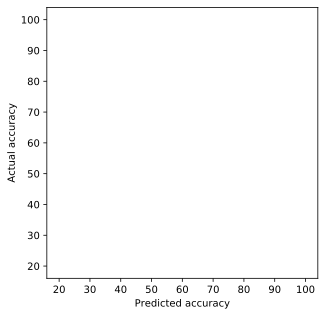

In [17]:
plt.figure(figsize=(5, 5))
plt.xlim((20, 100))
plt.ylim((20, 100))
plt.axis('scaled')
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
plt.scatter(comparisons['predicted'], comparisons['accuracy'], c=comparisons['split_num'])